In [2]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.2 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets
import nibabel as nib
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import pydicom as dicom

from IPython.display import HTML
from tqdm import tqdm

## 파일 가져오기

In [4]:
from google.colab import drive
import os

In [5]:
base_path = "/content/drive/MyDrive/rsna_data/"
img_dir = "/content/drive/png_test_csm"

In [ ]:
train_csv = f"{base_path}/train.csv"

## 데이터 살펴보기

In [ ]:
train = pd.read_csv(train_csv)
train.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [ ]:
train.shape

(3147, 15)

In [ ]:
train.describe()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
count,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000
mean,32664.239593,0.979663,0.020337,0.936447,0.063553,0.942167,0.036543,0.021290,0.897998,0.082301,0.019701,0.887512,0.063235,0.049253,0.271687
std,18792.043458,0.141172,0.141172,0.243993,0.243993,0.233464,0.187666,0.144373,0.302699,0.274866,0.138994,0.316016,0.243424,0.216431,0.444900
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16355.500000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,32195.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,49302.500000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,65508.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#결측치 확인
print(train.isnull().sum())

patient_id               0
bowel_healthy            0
bowel_injury             0
extravasation_healthy    0
extravasation_injury     0
kidney_healthy           0
kidney_low               0
kidney_high              0
liver_healthy            0
liver_low                0
liver_high               0
spleen_healthy           0
spleen_low               0
spleen_high              0
any_injury               0
dtype: int64


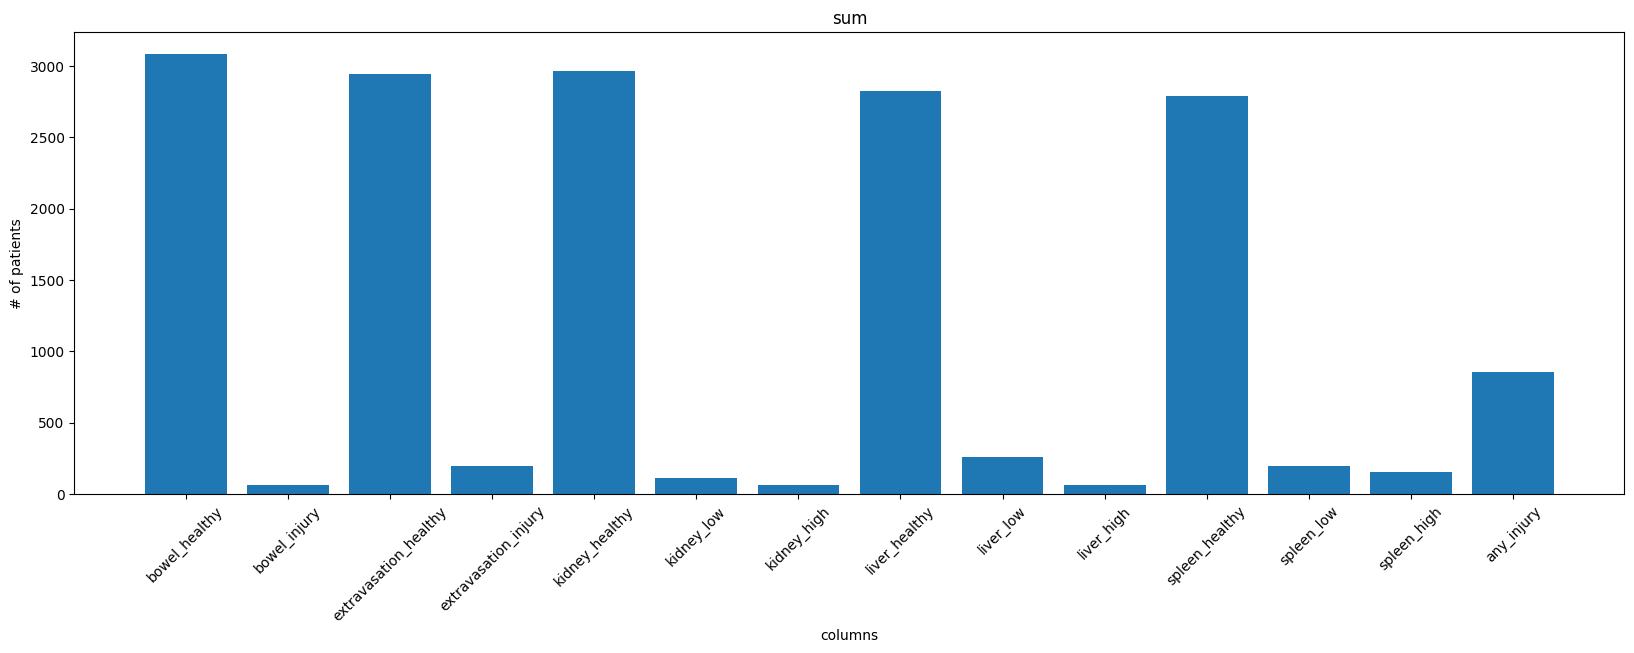

In [ ]:
# 비율 확인
data_without_id = train.drop('patient_id', axis=1)

id_counts = data_without_id.apply(lambda x: (x >= 1).sum())

plt.figure(figsize=(20, 6))
plt.bar(id_counts.index, id_counts.values)
plt.xlabel('columns')
plt.ylabel('# of patients')
plt.title('sum')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#상관 관계 확인
# 건강한 경우
health_columns = [
    "bowel_healthy", "extravasation_healthy", "kidney_healthy",
    "liver_healthy", "spleen_healthy",
]

<Axes: >

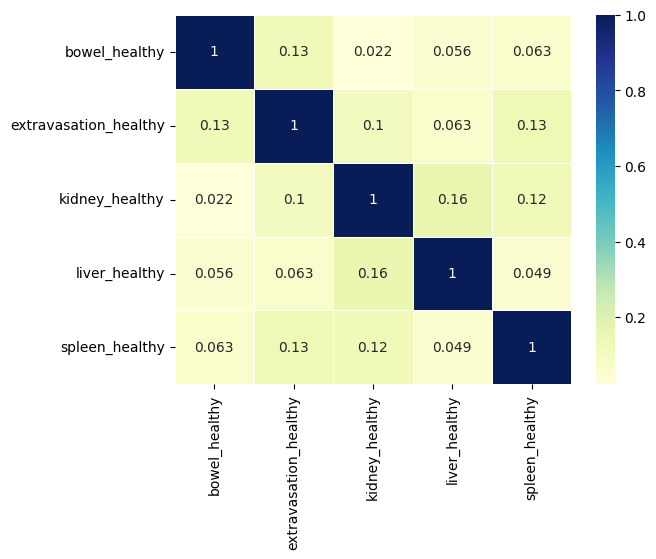

In [ ]:
sns.heatmap(train[health_columns].corr(), cmap='YlGnBu', annot=True, linewidths = .5)

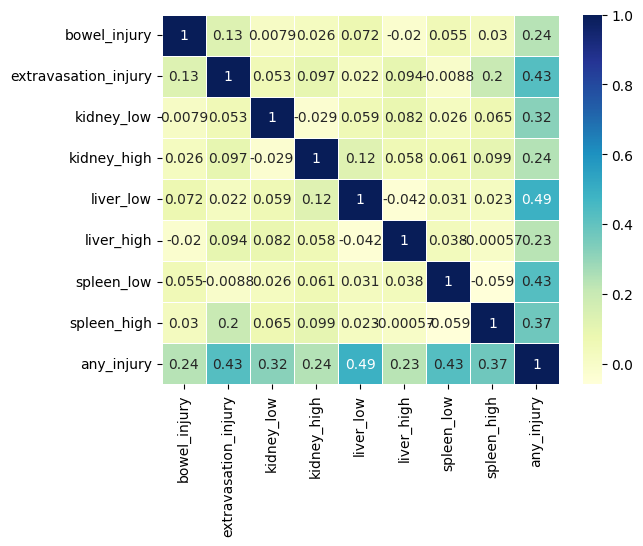

In [ ]:
#히트맵 - 부상 경우
injury_columns = [
    "bowel_injury", "extravasation_injury",
    "kidney_low", "kidney_high",
    "liver_low", "liver_high",
    "spleen_low", "spleen_high",
    "any_injury"
]

corr = train[injury_columns].corr()

sns.heatmap(corr, annot=True, cmap='YlGnBu', linewidths=.5);

## 이미지 확인

In [ ]:
img = f"{base_path}/train_images/10004/21057/1001.dcm"
img_dat = dicom.read_file(img)

img_dat

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.123.12345.1.2.3.10004.1.1001
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.3.123456.4.5.1234.1.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.123.12345.1.2.3.10004.1.1001
(0008, 0023) Content Date                        DA: '20230721'
(0008, 0033) Content Time                        TM: '232531.439438'
(0010, 0020) Patient ID                          LO: '10004'
(0018, 0050) Slice Thickness                     DS: '1.0'
(0018, 0060) KVP                                 DS: '90.0'
(0018, 5100) Patient Position                    CS: 'HFS'
(002

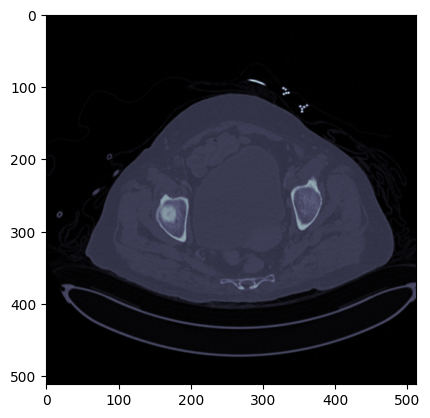

In [ ]:
plt.imshow(img_dat.pixel_array, cmap=plt.cm.bone);

## image_level_labels
Train only. Identifies specific images that contain either **bowel or extravasation** injuries.

In [ ]:
img_label_df = pd.read_csv(f"{base_path}/image_level_labels.csv")
img_label_df.head()

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation


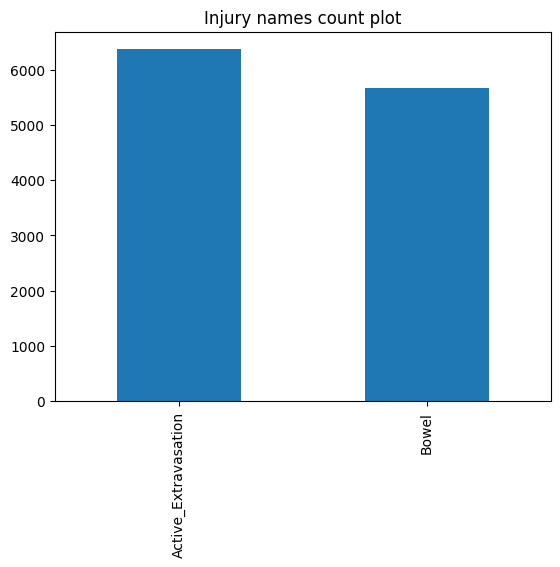

In [ ]:
img_label_df.injury_name.value_counts().plot(kind = 'bar');
plt.title('Injury names count plot');

patient_id'가 10004이고 'series_id'가 21057 인 경우 이미지들

In [ ]:
patient_10004_df = train[train['patient_id'] == 10004]
print(patient_10004_df)

   patient_id  bowel_healthy  bowel_injury  extravasation_healthy  \
0       10004              1             0                      0   

   extravasation_injury  kidney_healthy  kidney_low  kidney_high  \
0                     1               0           1            0   

   liver_healthy  liver_low  liver_high  spleen_healthy  spleen_low  \
0              1          0           0               0           0   

   spleen_high  any_injury  
0            1           1  


In [ ]:
EV_instances = img_label_df[(img_label_df['patient_id'] == 10004) & (img_label_df['series_id'] == 21057)].instance_number.values

In [ ]:
imgs = []
for i in EV_instances:
    imgs.append(os.path.join(base_path+'train_images/10004/21057/', str(i)+'.dcm'))

In [ ]:
len(imgs)

49

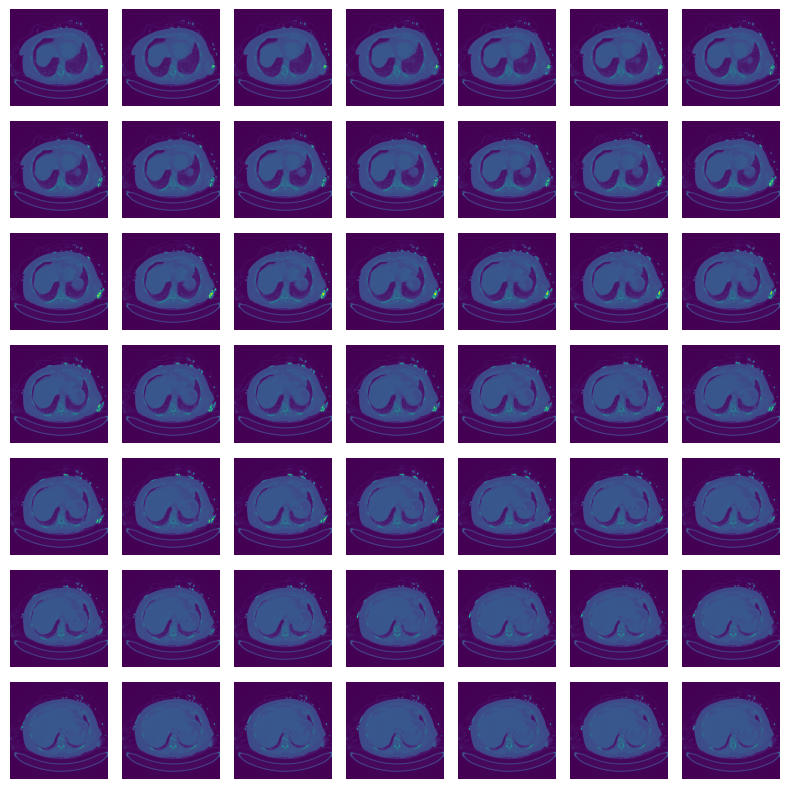

In [ ]:
# 그림판 생성
fig, axes = plt.subplots(7, 7, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        img_dat = dicom.read_file(imgs[i])
        img_array = img_dat.pixel_array
        ax.imshow(img_array)
        ax.axis('off')

plt.tight_layout()
plt.show()

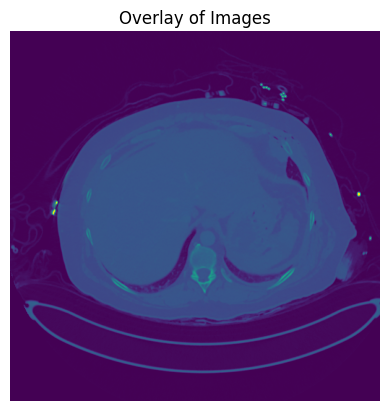

In [ ]:
# 이미지를 겹쳐서 표시할 그림 생성
fig, ax = plt.subplots()

# 각 이미지를 읽어서 겹쳐서 그림에 표시
for img_path in imgs:
    img_dat = dicom.read_file(img_path)
    ax.imshow(img_dat.pixel_array, alpha=0.5)  # 이미지를 투명도(alpha)를 조절하여 겹쳐서 표시

# 그림에 제목 등을 추가할 수 있습니다.
plt.title('Overlay of Images')
plt.axis('off')  # 축을 숨기거나 표시하려면 여기서 조절

# 그림을 표시
plt.show()

## series_meta.csv 확인

- incomplete_organ이 1인 경우 어떻게 하면 좋을지?
- aortic_hu에 대한 처리를 어떻게 할지? (시계열 분석..?)



In [ ]:
train_series_meta = pd.read_csv(f"{base_path}/train_series_meta.csv")
train_series_meta.head()

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


In [ ]:
class_counts = train_series_meta['incomplete_organ'].value_counts()
print(class_counts)

0    4398
1     313
Name: incomplete_organ, dtype: int64


## segmentation 파일 확인

In [ ]:
seg_files = os.listdir(base_path +'segmentations')

In [ ]:
#파일 이름 숫자로만 바꿔주기
seg_files = [tok[:-4] for tok in seg_files]
len(seg_files)

207

**train_dicom 파일 없음**

In [ ]:
test_dicom_tag = pd.read_parquet("/content/drive/MyDrive/rsna_data/train_dicom_tags.parquet")

FileNotFoundError: ignored

In [ ]:
test_dicom_tag.head()

,BitsAllocated,BitsStored,Columns,ContentDate,ContentTime,FrameOfReferenceUID,HighBit,ImageOrientationPatient,ImagePositionPatient,InstanceNumber,...,StudyInstanceUID,WindowCenter,WindowWidth,FileMetaInformationVersion,ImplementationClassUID,ImplementationVersionName,MediaStorageSOPClassUID,MediaStorageSOPInstanceUID,TransferSyntaxUID,path
0,16,12,512,20230722,002246.191887,1.2.826.0.1.3680043.8.498.92271913265819460212...,11,"[1, 0, 0, 0, 1, 0]","[-225.609375, -299.609375, -1099]",30,...,1.2.123.12345.1.2.3.48843,50.0,400.0,b'\x00\x01',1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.48843.1.30,1.2.840.10008.1.2.5,test_images/48843/62825/30.dcm
1,16,16,512,20230722,003830.929278,1.2.826.0.1.3680043.8.498.70045142309401550406...,15,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[-214.26, -203.431, -172.802]",30,...,1.2.123.12345.1.2.3.50046,50.0,400.0,b'\x00\x01',1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.50046.1.30,1.2.840.10008.1.2.5,test_images/50046/24574/30.dcm
2,16,12,512,20230722,005441.112500,1.2.826.0.1.3680043.8.498.64877973120200061370...,11,"[1, 0, 0, 0, 1, 0]","[-179.1416015625, -343.1416015625, -477]",30,...,1.2.123.12345.1.2.3.63706,50.0,400.0,b'\x00\x01',1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.63706.1.30,1.2.840.10008.1.2.5,test_images/63706/39279/30.dcm


In [ ]:
#path 이용해서 series랑 file 정보 빼주기
train_dicom_tag['series_id'] = train_dicom_tag['path'].apply(lambda x: x.split('/')[-2:][0])
train_dicom_tag['file_path'] = train_dicom_tag['path'].apply(lambda x: x.split('/')[-1:][0])

In [ ]:
test_dicom_tag.head()

,BitsAllocated,BitsStored,Columns,ContentDate,ContentTime,FrameOfReferenceUID,HighBit,ImageOrientationPatient,ImagePositionPatient,InstanceNumber,...,WindowWidth,FileMetaInformationVersion,ImplementationClassUID,ImplementationVersionName,MediaStorageSOPClassUID,MediaStorageSOPInstanceUID,TransferSyntaxUID,path,series_id,file_path
0,16,12,512,20230722,002246.191887,1.2.826.0.1.3680043.8.498.92271913265819460212...,11,"[1, 0, 0, 0, 1, 0]","[-225.609375, -299.609375, -1099]",30,...,400.0,b'\x00\x01',1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.48843.1.30,1.2.840.10008.1.2.5,test_images/48843/62825/30.dcm,62825,30.dcm
1,16,16,512,20230722,003830.929278,1.2.826.0.1.3680043.8.498.70045142309401550406...,15,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[-214.26, -203.431, -172.802]",30,...,400.0,b'\x00\x01',1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.50046.1.30,1.2.840.10008.1.2.5,test_images/50046/24574/30.dcm,24574,30.dcm
2,16,12,512,20230722,005441.112500,1.2.826.0.1.3680043.8.498.64877973120200061370...,11,"[1, 0, 0, 0, 1, 0]","[-179.1416015625, -343.1416015625, -477]",30,...,400.0,b'\x00\x01',1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.63706.1.30,1.2.840.10008.1.2.5,test_images/63706/39279/30.dcm,39279,30.dcm


##NIFTI 파일 보기
Segmentation 에서
- 다 동일하기 때문에 90도 돌려줘야 함

In [ ]:
import nibabel as nib

def check_patient_position(nifti_file_path):
    try:
        # NIFTI 파일 로드
        img = nib.load(nifti_file_path)

        # 메타데이터에서 환자 위치 검색
        affine = img.affine
        orientation = nib.aff2axcodes(affine)

        # 환자 방향 결정
        if orientation == ('R', 'A', 'S'):
            return "supine position"
        else:
            return f"NOT supine, {orientation}"
    except Exception as e:
        return str(e)

result_list = []

# seg_files 리스트에 있는 각 NIFTI 파일에 대해 환자 위치 확인
for p in seg_files:
    result = check_patient_position(base_path+'segmentations/'+p+'.nii')
    result_list.append(result)


In [ ]:
result_list

["NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT supine, ('L', 'A', 'S')",
 "NOT su

In [ ]:
import cv2

def plot_nifti_dicom_slice(p):
    fig = plt.figure(figsize=(18,4))
    file_path = base_path+"segmentations/"+p+".nii"

    nifti_img = nib.load(file_path)
    image_data = nifti_img.get_fdata()

    image_data = np.transpose(image_data, [2, 1, 0])
    image_data = np.rot90(image_data, -1, (1,2))
    image_data = image_data[::-1,:,:]
    image_data = np.transpose(image_data, [2, 1, 0])
    image_data = image_data[::1, ::1, ::1]

    ax1 = fig.add_subplot(1, 3, 1)
    # Choose a slice index (for example, the middle slice along the z-axis)
    slice_index = image_data.shape[2] // 2
    print("slice_index:", slice_index)

    # Plot the selected slice
    niiimg = image_data[:, :, slice_index]
    sc = ax1.imshow(niiimg)
    plt.colorbar(sc)

    filtered_df = test_dicom_tag[test_dicom_tag['path'].str.contains(p)]
    if filtered_df.empty:
      raise ValueError(f"No rows with path containing '{p}' found.")
    else:
      dcm_p = base_path + filtered_df.sort_values('InstanceNumber').reset_index(drop=True).iloc[slice_index]['path']

    ax2 = fig.add_subplot(1, 3, 2)
    img = dicom.dcmread(dcm_p).pixel_array
    ax2.imshow(img, cmap=plt.cm.bone)
    ax2.set_title("series ID : " + p)

    niiimg = niiimg.astype('float32')

    img = img.astype('float32')
    # Normalize img to a range of 0 to 1
    min_val = img.min()
    max_val = img.max()
    img = (img - min_val) / (max_val - min_val)

    ax3 = fig.add_subplot(1, 3, 3)
    blend=cv2.addWeighted(img,0.7,niiimg,0.3,0)
    ax3.imshow(blend)

    plt.show()

slice_index: 241


ValueError: ignored

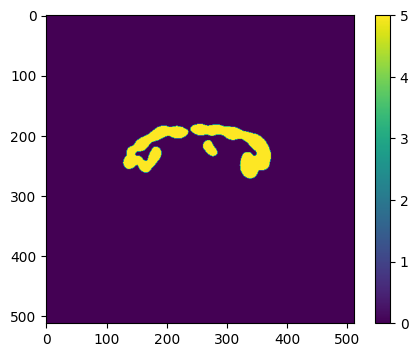

In [ ]:
for p in seg_files[:10]:
    plot_nifti_dicom_slice(p)